# This notebook is used to train the encoder-decoder network without slides in the middle.

# The aim is to regenerate the input image without any changes.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/drive/My Drive/UTK_inthewild/part1.tar.gz' .
!cp '/content/drive/My Drive/UTK_inthewild/part2.tar.gz' .
!cp '/content/drive/My Drive/UTK_inthewild/part3.tar.gz' .

In [0]:
!mkdir images
!tar xzf part1.tar.gz -C images
!tar xzf part2.tar.gz -C images
!tar xzf part3.tar.gz -C images
!mv images/part1/* images
!mv images/part2/* images
!mv images/part3/* images

In [0]:
!rm -r images/part1
!rm -r images/part2
!rm -r images/part3

In [0]:
!ls -l images | wc -l

24109


In [0]:
import tensorflow as tf

tf.enable_eager_execution()

import tensorflow.keras as keras
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

import tensorflow.keras.backend as K

import numpy as np
import cv2
import os
import gc

from google.colab.patches import cv2_imshow

 # Instance Normalization, wrapped in a keras layer

In [0]:
class InstanceNormalization(Layer):
    def __init__(self, **kwargs):
        super(InstanceNormalization, self).__init__()

    def build(self, input_shape):
        depth = input_shape[3]
        self.scale = self.add_weight(name="scale_"+str(depth),
                                     shape=[depth], 
                                     initializer=tf.random_normal_initializer(1.0, 0.02, dtype=tf.float32),
                                     dtype=tf.float32
                                    )
            
        self.offset = self.add_weight(name="offset_"+str(depth),
                                      shape=[depth], 
                                      initializer=tf.constant_initializer(0.0),
                                      dtype=tf.float32
                                    )
        super(InstanceNormalization, self).build(input_shape)
        
    def call(self, input_):
        mean, variance = tf.nn.moments(input_, axes=[1,2], keep_dims=True)
        epsilon = 1e-5
        inv = tf.rsqrt(variance + epsilon)
        normalized = (input_-mean)*inv
        return self.scale*normalized + self.offset

# Residual Block implementation. Consistes of two convolutional layers. Input to first is added to output of second.

In [0]:
class Residual(Layer):
    def __init__(self, dim=256, ks=3, s=1, padding='VALID', stddev=0.02, from_list=None, **kwargs):
        self.dim = dim
        self.ks = ks
        self.s = s
        self.from_list = from_list
        self.padding=padding
        self.stddev=stddev
        super(Residual, self).__init__()

    def build(self, input_shape):
        self.conv2d1 = Conv2D(filters=self.dim, kernel_size=self.ks, strides=self.s, padding=self.padding, activation=None,
                            kernel_initializer=tf.truncated_normal_initializer(stddev=self.stddev),
                            bias_initializer=None)
        self.instnorm1 = InstanceNormalization()
        self.relu1 = ReLU()
        self.conv2d2 = Conv2D(filters=self.dim, kernel_size=self.ks, strides=self.s, padding=self.padding, activation=None,
                            kernel_initializer=tf.truncated_normal_initializer(stddev=self.stddev),
                            bias_initializer=None)
        self.instnorm2 = InstanceNormalization()
        
        super(Residual, self).build(input_shape)
        
    def call(self, x):
        p = int((self.ks - 1) / 2)
        y = tf.pad(x, [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT")

        y = self.instnorm1(self.conv2d1(y))
        y = tf.pad(self.relu1(y), [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT")
        y = self.instnorm2(self.conv2d2(y))
        return y + x 


In [0]:
def instance_norm(inp, name="instance_norm"):
    return InstanceNormalization()(inp)

In [0]:
def conv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME', name="conv2d"):
    return Conv2D(filters=output_dim, kernel_size=ks, strides=s, padding=padding, activation=None,
                            kernel_initializer=tf.truncated_normal_initializer(stddev=stddev),
                            bias_initializer=None)(input_)

def deconv2d(input_, output_dim, ks=4, s=2, stddev=0.02, name="deconv2d"):
    return Conv2DTranspose(filters=output_dim, kernel_size=ks, strides=s, padding='SAME', activation=None,
                                    kernel_initializer=tf.truncated_normal_initializer(stddev=stddev),
                                    bias_initializer=None)(input_)

def lrelu(x, leak=0.2, name="lrelu"):
    return LeakyReLU(leak)(x)

@tf.function
def abs_criterion(in_, target):
    return tf.reduce_mean(tf.abs(in_ - target))

@tf.function
def mae_criterion(in_, target):
    return tf.reduce_mean((in_-target)**2)

@tf.function
def sce_criterion(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

In [0]:
for d in os.listdir('.'):
    if d[0].isdigit():
        os.system('rm -r ' + d)

# Functions to create the generator and discriminator, along with helpers. Also contains functions to extract encoder and decoder parts separately.

In [0]:
def make_generator_resnet(name="generator"):

    inp = Input((128, 128, 3))
    gf_dim = 64
    output_c_dim = 3

    c0 = tf.pad(inp, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
    c1 = ReLU()(instance_norm(conv2d(c0, gf_dim, 7, 1, padding='VALID', name='g_e1_c'), 'g_e1_bn'))
    c2 = ReLU()(instance_norm(conv2d(c1, gf_dim*2, 3, 2, name='g_e2_c'), 'g_e2_bn'))
    c3 = ReLU()(instance_norm(conv2d(c2, gf_dim*4, 3, 2, name='g_e3_c'), 'g_e3_bn'))        # 64 *64
    
    r1 = Residual(dim=gf_dim*4, name='g_r1')(c3)
    r2 = Residual(dim=gf_dim*4, name='g_r2')(r1)
    r3 = Residual(dim=gf_dim*4, name='g_r3')(r2)
    r4 = Residual(dim=gf_dim*4, name='g_r4')(r3)
    r5 = Residual(dim=gf_dim*4, name='g_r5')(r4)
    r6 = Residual(dim=gf_dim*4, name='g_r6')(r5)
    r7 = Residual(dim=gf_dim*4, name='g_r7')(r6)
    r8 = Residual(dim=gf_dim*4, name='g_r8')(r7)
    r9 = Residual(dim=gf_dim*4, name='g_r9')(r8)

    d1 = deconv2d(r9, gf_dim*2, 3, 2, name='g_d1_dc')
    d1 = ReLU()(instance_norm(d1, 'g_d1_bn'))
    d2 = deconv2d(d1, gf_dim, 3, 2, name='g_d2_dc')
    d2 = ReLU()(instance_norm(d2, 'g_d2_bn'))
    d3 = ChannelConvolution(22, 21)(d2)
    d3 = Activation('tanh')(d3)
    pred = d3
    m = Model(inputs=[inp], outputs=[pred])
    return m

def get_generator_parts(weights=None, name='generator'):
    gen = make_generator_resnet()
    if weights:
        gen.load_weights(weights)

    gf_dim = 64
    part1 = gen.layers[:11]
    part2 = gen.layers[11:20]
    part3 = gen.layers[20:]

    inp = Input((128, 128, 3))
    x = inp
    for layer in part1[1:]:
        x = layer(x)

    model1 = Model(inputs=[inp], outputs=[x])

    slidepart = Input((32, 32, 256))
    x = slidepart
    for layer in part2:
        x = layer(x)

    model_slide = Model(inputs=[slidepart], outputs=[x])

    inp = Input((32, 32, 256))
    x = inp
    for layer in part3:
        x = layer(x)
    
    model2 = Model(inputs=[inp], outputs=[x])
    return model1, model_slide, model2

def make_conv_deconv(weights=None):
    gen = make_generator_resnet()
    if weights:
        gen.load_weights(weights)

    gf_dim = 64
    part1 = gen.layers[:11]
    part2 = gen.layers[20:]

    inp = Input((128, 128, 3))
    x = inp
    for layer in part1[1:]:
        x = layer(x)

    model1 = Model(inputs=[inp], outputs=[x])

    inp = Input((32, 32, 256))
    x = inp
    for layer in part2:
        x = layer(x)
    
    model2 = Model(inputs=[inp], outputs=[x])
    return model1, model2

def make_new_slide(gf_dim=64):
    inp = Input((32, 32, 256))
    r1 = Residual(dim=gf_dim*4, name='g_r1')(slidepart)
    r2 = Residual(dim=gf_dim*4, name='g_r2')(r1)
    r3 = Residual(dim=gf_dim*4, name='g_r3')(r2)
    r4 = Residual(dim=gf_dim*4, name='g_r4')(r3)
    r5 = Residual(dim=gf_dim*4, name='g_r5')(r4)
    r6 = Residual(dim=gf_dim*4, name='g_r6')(r5)
    r7 = Residual(dim=gf_dim*4, name='g_r7')(r6)
    r8 = Residual(dim=gf_dim*4, name='g_r8')(r7)
    r9 = Residual(dim=gf_dim*4, name='g_r9')(r8)

    model_slide = Model(inputs=[inp], outputs=[r9])
    return model_slide

def get_slide(name, gf_dim=64, trainable=False):
    inp = Input((32, 32, 256))
    r1 = Residual(dim=gf_dim*4, name='g_r1')(slidepart)
    r2 = Residual(dim=gf_dim*4, name='g_r2')(r1)
    r3 = Residual(dim=gf_dim*4, name='g_r3')(r2)
    r4 = Residual(dim=gf_dim*4, name='g_r4')(r3)
    r5 = Residual(dim=gf_dim*4, name='g_r5')(r4)
    r6 = Residual(dim=gf_dim*4, name='g_r6')(r5)
    r7 = Residual(dim=gf_dim*4, name='g_r7')(r6)
    r8 = Residual(dim=gf_dim*4, name='g_r8')(r7)
    r9 = Residual(dim=gf_dim*4, name='g_r9')(r8)

    model_slide = Model(inputs=[inp], outputs=[r9])

    weights = '/content/drive/My Drive/UTK_inthewild/slide_' + name + '.h5'
    model_slide.load_weights(weights)
    model_slide.trainable=trainable
    return model_slide

def save_slide(model, name, overwrite=False):
    weights = '/content/drive/My Drive/UTK_inthewild/slide_' + name + '.h5'
    if os.path.exists(weights) and overwrite==False:
        print(weights, " already exists. Please choose a different name.")
    else:
        model.save_weights(weights)

In [0]:
conv, deconv = make_conv_deconv()
conv.summary()
deconv.summary()

W0814 14:18:18.566502 139783471347584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.rsqrt is deprecated. Please use tf.math.rsqrt instead.



3
3
3
3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_MirrorPad (Tenso multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      9472      
_________________________________________________________________
instance_normalization (Inst (None, 128, 128, 64)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)   

In [0]:
inp = Input((128, 128, 3))
x = conv(inp)
x = deconv(x)
enc_dec_model = Model(inputs=[inp], outputs=[x])
enc_dec_model.summary()

3
3
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 256)       379392    
_________________________________________________________________
model_2 (Model)              (None, 128, 128, 3)       1450560   
Total params: 1,829,952
Trainable params: 1,829,952
Non-trainable params: 0
_________________________________________________________________


In [0]:
images = os.listdir('images')
def image_batch_generator(batch_size):
    while True:
        imgs = []
        img_names = np.random.choice(images, size=batch_size, replace=False)
        for name in img_names:
            img = cv2.imread('images/'+name)
            img = (cv2.resize(img, (128, 128)) / 127.5) - 1.0
            imgs.append(img.astype(np.float32))
        
        X = np.stack(imgs)
        yield X, X


In [0]:
bs = 80
opt = tf.keras.optimizers.Adam(0.0003, beta_1=0.5)
enc_dec_model.compile(optimizer=opt, loss='mae', metrics=['accuracy', 'mse'])
enc_dec_model.fit_generator(image_batch_generator(bs), steps_per_epoch=int(len(images) / bs), epochs=100)

Epoch 1/100
301/301 [==============================] - 470s 2s/step - loss: 0.0658 - acc: 0.7798 - mean_squared_error: 0.0087
Epoch 2/100
301/301 [==============================] - 470s 2s/step - loss: 0.0644 - acc: 0.7817 - mean_squared_error: 0.0084
Epoch 3/100
301/301 [==============================] - 467s 2s/step - loss: 0.0636 - acc: 0.7846 - mean_squared_error: 0.0082
Epoch 4/100
301/301 [==============================] - 467s 2s/step - loss: 0.0629 - acc: 0.7866 - mean_squared_error: 0.0080
Epoch 5/100
301/301 [==============================] - 468s 2s/step - loss: 0.0620 - acc: 0.7858 - mean_squared_error: 0.0078
Epoch 6/100
301/301 [==============================] - 466s 2s/step - loss: 0.0618 - acc: 0.7851 - mean_squared_error: 0.0078
Epoch 7/100
301/301 [==============================] - 467s 2s/step - loss: 0.0611 - acc: 0.7887 - mean_squared_error: 0.0076
Epoch 8/100
301/301 [==============================] - 467s 2s/step - loss: 0.0602 - acc: 0.7848 - mean_squared_error:

E0814 17:37:50.599755 139783471347584 ultratb.py:982] An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



KeyboardInterrupt: ignored

In [0]:
bs = 80
opt = tf.keras.optimizers.Adam(0.00001, beta_1=0.5)
enc_dec_model.compile(optimizer=opt, loss='mae', metrics=['accuracy', 'mse'])
enc_dec_model.fit_generator(image_batch_generator(bs), steps_per_epoch=int(len(images) / bs), epochs=100)

Epoch 1/100
265/301 [=========================>....] - ETA: 55s - loss: 0.0549 - acc: 0.7951 - mean_squared_error: 0.0064

E0814 18:05:04.397035 139783471347584 ultratb.py:982] An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



KeyboardInterrupt: ignored

In [0]:
enc_dec_model.save('/content/drive/My Drive/UTK_inthewild/enc_dec.h5')

TypeError: ignored

In [0]:
bs = 64
opt = tf.keras.optimizers.Adam(0.00001)
enc_dec_model.compile(optimizer=opt, loss='mae', metrics=['accuracy', 'mse'])
enc_dec_model.fit_generator(image_batch_generator(bs), steps_per_epoch=int(len(images) / bs), epochs=10)

In [0]:
conv.save_weights('/content/drive/My Drive/UTK_inthewild/conv.h5')
deconv.save_weights('/content/drive/My Drive/UTK_inthewild/deconv.h5')

3
3


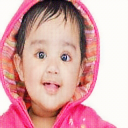

Done  0
3
3


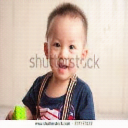

Done  1
3
3


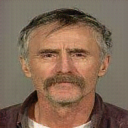

Done  2
3
3


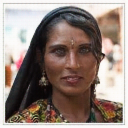

Done  3
3
3


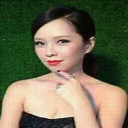

Done  4
3
3


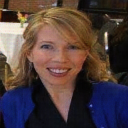

Done  5
3
3


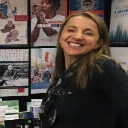

Done  6
3
3


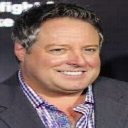

Done  7
3
3


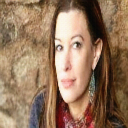

Done  8
3
3


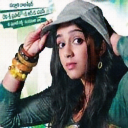

Done  9


In [0]:
# images = os.listdir('images')
for i in range(10):
    img = 'images/'+images[i]
    img = cv2.imread(img)
    img = cv2.resize(img, (128, 128)).astype(np.float32)
    cv2.imwrite(str(i)+'_orig.jpg', img)
    img = np.expand_dims(((img / 127.5) - 1.0), axis=0)
    img = enc_dec_model(img)
    img = np.squeeze((1.0 + img) * 127.5).astype(np.float32)
    cv2.imwrite(str(i)+'.jpg', img)
    cv2_imshow(img)
    print("Done ", i)

# save_slide(part2, 'old2young')

In [0]:
conv.save('/content/drive/My Drive/UTK_inthewild/conv_model.h5')
deconv.save('/content/drive/My Drive/UTK_inthewild/deconv_model.h5')

# Above this cell, padding was applied as a tensorflow operation using `tf.pad()`. The code below creates a keras Lambda layer as a wrapper, ports previously saved weights to the model thus created, and tests it.

In [0]:
inp = Input((128, 128, 3))
x = Lambda(lambda x: tf.pad(x, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT"))(inp)

conv_others = conv.layers[2:]
for layer in conv_others:
    x = layer(x)

model = Model(inputs=[inp], outputs=[x])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 134, 134, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      9472      
_________________________________________________________________
instance_normalization (Inst (None, 128, 128, 64)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)       256 

3
3


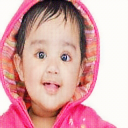

Done  0
3
3


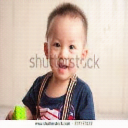

Done  1
3
3


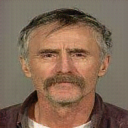

Done  2
3
3


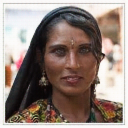

Done  3
3
3


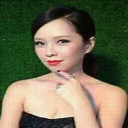

Done  4
3
3


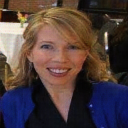

Done  5
3
3


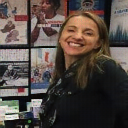

Done  6
3
3


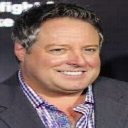

Done  7
3
3


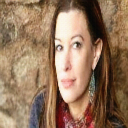

Done  8
3
3


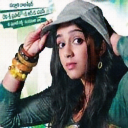

Done  9


In [0]:
for i in range(10):
    img = 'images/'+images[i]
    img = cv2.imread(img)
    img = cv2.resize(img, (128, 128)).astype(np.float32)
    cv2.imwrite(str(i)+'_orig.jpg', img)
    img = np.expand_dims(((img / 127.5) - 1.0), axis=0)
    img = model(img)
    img = deconv(img)
    img = np.squeeze((1.0 + img) * 127.5).astype(np.float32)
    cv2.imwrite(str(i)+'.jpg', img)
    cv2_imshow(img)
    print("Done ", i)



In [0]:
model.save('/content/drive/My Drive/UTK_inthewild/conv_model.h5')

In [0]:
test = tf.keras.models.load_model('/content/drive/My Drive/UTK_inthewild/conv_model.h5', {'InstanceNormalization': InstanceNormalization, 
                                                                                          'ChannelConvolution': ChannelConvolution,
                                                                                          'tf': tf})
test.summary()

W0814 18:07:39.769818 139783471347584 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 134, 134, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      9472      
_________________________________________________________________
instance_normalization_5 (In (None, 128, 128, 64)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
instance_normalization_6 (In (None, 64, 64, 128)       256 

In [0]:
inp = Input((32, 32, 256))
x = inp
deconv_others = deconv.layers[1:7]
for layer in deconv_others:
    x = layer(x)

x = Lambda(lambda x: tf.pad(x, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT"))(x)
deconv_others = deconv.layers[8:]
for layer in deconv_others:
    x = layer(x)

model = Model(inputs=[inp], outputs=[x])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 256)]     0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 128)       295040    
_________________________________________________________________
instance_normalization_3 (In (None, 64, 64, 128)       256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 64)      73792     
_________________________________________________________________
instance_normalization_4 (In (None, 128, 128, 64)      128       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 128, 128, 64)      0   

In [0]:
for i in range(10):
    img = 'images/'+images[i]
    img = cv2.imread(img)
    img = cv2.resize(img, (128, 128)).astype(np.float32)
    cv2.imwrite(str(i)+'_orig.jpg', img)
    img = np.expand_dims(((img / 127.5) - 1.0), axis=0)
    img = test(img)
    img = model(img)
    img = np.squeeze((1.0 + img) * 127.5).astype(np.float32)
    cv2.imwrite(str(i)+'.jpg', img)
    cv2_imshow(img)
    print("Done ", i)



In [0]:
model.save('/content/drive/My Drive/UTK_inthewild/deconv_model.h5')

In [0]:
del model
model = tf.keras.models.load_model('/content/drive/My Drive/UTK_inthewild/deconv_model.h5', {'InstanceNormalization': InstanceNormalization, 'tf': tf})
model.summary()

In [0]:
for i in range(10):
    img = 'images/'+images[i]
    img = cv2.imread(img)
    img = cv2.resize(img, (128, 128)).astype(np.float32)
    cv2.imwrite(str(i)+'_orig.jpg', img)
    img = np.expand_dims(((img / 127.5) - 1.0), axis=0)
    img = test(img)
    img = model(img)
    img = np.squeeze((1.0 + img) * 127.5).astype(np.float32)
    cv2.imwrite(str(i)+'.jpg', img)
    cv2_imshow(img)
    print("Done ", i)

